# Import packages, data and define useful functions

In [1]:
# Import all important packages and set parameters
!pip install corner
from __future__ import division
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm, amsmath, siunitx}'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 12
import torch
import torch.nn as nn
import numpy as np
from math import pi 
import seaborn as sns
import pandas as pd
import corner
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Fixing seeds for reproducibility
torch.manual_seed(2)
np.random.seed(2)

In [3]:
# Imports for feature extraction
import sys
sys.path.insert(1, '/content/drive/MyDrive/Universität Bern/Master/Master Thesis/Python files/Experiment_1 (NF example with feature extraction in nflows)/Experiment_1_V1')
import pandas as pd
import utils_features as uf
from utils_features import line_parameters
from tqdm import tqdm
import importlib
from scipy.interpolate import interp1d
from scipy.signal import lfilter, butter 

In [4]:
# Define function to extract features from spectra
def extract_features(nprof):
    '''
    Extract features from dataset of spectra
    '''
    k = uf.line_parameters['Mg II k']['k']
    kl = uf.line_parameters['Mg II k']['kl']
    kr = uf.line_parameters['Mg II k']['kr']

    k2l = uf.line_parameters['Mg II k']['k2l']
    k2r = uf.line_parameters['Mg II k']['k2r']

    h = uf.line_parameters['Mg II k']['h']
    hl = uf.line_parameters['Mg II k']['hl']
    hr = uf.line_parameters['Mg II k']['hr']

    sm = uf.line_parameters['Mg II k']['sm']
    wing = uf.line_parameters['Mg II k']['wing']

    lambda_min = uf.line_parameters['Mg II k']['lambda_min']
    lambda_max = uf.line_parameters['Mg II k']['lambda_max']
    n_bins = uf.line_parameters['Mg II k']['n_bins']

    importlib.reload(uf)
    # Calculate each spectrums normalized cumulative distribution function 
    ncdfs = uf.NCDFs(nprof[:,kl:kr])
    # Find the locations of the first, second and third quartiles
    qs = uf.quartiles(ncdfs)
    q1, q2, q3 = qs[:,0], qs[:,1], qs[:,2]
    # Extract 10 features of each line and store in a pandas DataFrame 
    # df_features = extract_features_SiIV(nprof, save_path=None)
    df_features = uf.extract_features_MgIIk(nprof, save_path=None)
    return df_features

In [5]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
print('Pytorch version:',torch.__version__)
if torch.cuda.is_available() is True:
    print(f'Device type: {torch.cuda.get_device_name(0)}')

Device: cpu
Pytorch version: 2.0.0+cpu


In [6]:
# Filter rows of nan-values from two datasets
def filter_nan_rows(arr1, arr2):
    'Filter NaN rows from two arrays of same row number; if there is NaN value in a row in one array, the same row is deleted in both arrays.'
    mask = ~np.isnan(arr1).any(axis=1)
    filtered_arr1 = arr1[mask]
    filtered_arr2 = arr2[mask]
    mask = ~np.isnan(arr2).any(axis=1)
    filtered_arr1 = arr1[mask]
    filtered_arr2 = arr2[mask]
    return filtered_arr1, filtered_arr2

In [7]:
spectra = np.load('C:/Users/zahnd/Google Drive/Universität Bern/Master/Master Thesis/Python files/Resources/test_spectra.npy')
features = np.load('C:/Users/zahnd/Google Drive/Universität Bern/Master/Master Thesis/Python files/Resources/test_features.npy')
spectra_f, features_f = filter_nan_rows(spectra, features)
labels = ['Center mass', 'Line width', 'Line asymmetry', 'Doppler', 'Triplet emission', 'KH ratio', 'K3H', 'Peak ratios', 'Peak separation', 'Total continuum']

In [8]:
# Define function to resize a 1-dimensional array to the three sigma range
def three_sigma(array):
    'Resizes a one-dimensional array of arbitrary length to the three sigma range'
    # Calculate mean and standard deviation
    mean = np.mean(array)
    std = np.std(array)

    # Define lower and upper bounds
    lower_bound = mean - 3*std
    upper_bound = mean + 3*std

    # Resize array within the three sigma range
    resized_array = np.clip(array, lower_bound, upper_bound)

    return resized_array

In [9]:
# Define function to plot density plots
def plot_dens(inp, n, inp_names=None, savename=None, title=None):
    'Plot n density plots of inp with 5 plots at most each row, all row entries for a given column of inp are taken as the distribution'
    ncols = min(5, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3*nrows))
    if title is not None:
        plt.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < n:
            sns.kdeplot(three_sigma(inp[:,i]), bw_method=0.2, ax=ax, label=('Characteristics:\n$\\mu =$ %s, $\\sigma =$ %s' %(round(np.mean(inp[:,i]),2), round(np.std(inp[:,i]),2))))           
            if inp_names != None:
                ax.set_title(f'{inp_names[i]}')
            else:
                ax.set_title(f'Density {i+1}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend(loc='best')
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename)
    else:
        plt.show()

In [10]:
# Define function to plot histograms
def plot_hist(inp, n, inp_names=None, savename=None, title=None):
    'Plot n histograms of inp with 5 plots at most each row, all row entries for a given column of inp are taken as the distribution'
    ncols = min(5, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3*nrows))
    if title is not None:
        plt.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.hist(three_sigma(inp[:,i]), bins=200, label=('Characteristics:\n$\\mu =$ %s, $\\sigma =$ %s' %(round(np.mean(inp[:,i]),2), round(np.std(inp[:,i]),2))))
            if inp_names != None:
                ax.set_title(f'{inp_names[i]}')
            else:
                ax.set_title(f'Histogram {i+1}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Number of values per bin')
            ax.legend(loc='best')
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename)
    else:
        plt.show()

In [11]:
# Define function to create training and testing datasets
def train_test(inp_arr1, inp_arr2, trainsec=0.8):
    'Split inp_arr1 and inp_arr2 into training and testing datasets, where by default 80% (trainsec=0.8) of the input data are assigned to the training dataset'
    if len(inp_arr1[:,0]) != len(inp_arr2[:,0]):
        print('Error: The two input arrays do not have the same length!')
        return
    split_int = int(len(inp_arr1[:,0])*trainsec)
    inp_arr1_train = inp_arr1[:split_int, :]
    inp_arr1_test = inp_arr1[split_int:, :]
    inp_arr2_train = inp_arr2[:split_int, :]
    inp_arr2_test = inp_arr2[split_int:, :]
    return inp_arr1_train, inp_arr2_train, inp_arr1_test, inp_arr2_test

# Create neccessary datasets

In [12]:
# Dictionary to save important information
class dictionary(dict): 
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [13]:
# Instantiate params dictionary
settings = dictionary()

In [14]:
from sklearn.cluster import KMeans
kmeans_spectra_f = KMeans(n_clusters=20, n_init=10).fit(spectra_f)
spectra_centroids = kmeans_spectra_f.cluster_centers_

In [15]:
idx_cat1 = 0
idx_cat2 = 19
spectra_cat1 = []
spectra_cat2 = []
for i in range(len(spectra_f)):
    if kmeans_spectra_f.labels_[i] == idx_cat1:
        spectra_cat1.append(spectra_f[i])
    if kmeans_spectra_f.labels_[i] == idx_cat2:
        spectra_cat2.append(spectra_f[i])
cat1_centroid = spectra_centroids[idx_cat1]
cat2_centroid = spectra_centroids[idx_cat2]
spectra_cat1 = np.array(spectra_cat1)
spectra_cat2 = np.array(spectra_cat2)
features_cat1 = np.array(extract_features(spectra_cat1))
features_cat2 = np.array(extract_features(spectra_cat2))
features_cat1, spectra_cat1 = filter_nan_rows(features_cat1, spectra_cat1)
features_cat2, spectra_cat2 = filter_nan_rows(features_cat2, spectra_cat2)

In [16]:
x_train1, y_train1, x_test1, y_test1 = train_test(features_cat1, spectra_cat1)
x_train2, y_train2, x_test2, y_test2 = train_test(features_cat2, spectra_cat2)
x_train = np.concatenate((x_train1, x_train2))
y_train = np.concatenate((y_train1, y_train2))
x_test = np.concatenate((x_test1, x_test2))
y_test = np.concatenate((y_test1, y_test2))

In [17]:
# Define input x and context y
x = np.concatenate((x_train, x_test)) # features
y = np.concatenate((y_train, y_test)) # spectra

# Standardize the input x and context y for training dataset
x_scaler_train = StandardScaler().fit(x_train)
y_scaler_train = StandardScaler().fit(y_train)
x_std_train = x_scaler_train.transform(x_train)
y_std_train = y_scaler_train.transform(y_train)

# Standardize the input x and context y for testing dataset
x_scaler_test = StandardScaler().fit(x_test)
y_scaler_test = StandardScaler().fit(y_test)
x_std_test = x_scaler_test.transform(x_test)
y_std_test = y_scaler_test.transform(y_test)

# Define base distribution z, such that z = f(x) for training dataset
z_train = MultivariateNormal(torch.zeros(x_std_train.shape[1]), torch.eye(x_std_train.shape[1])).rsample(sample_shape=(x_std_train.shape[0],)).detach().numpy()

# Define base distribution z, such that z = f(x) for testing dataset
z_test = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(x_std_test.shape[0],)).detach().numpy()

# Print shapes of training data
print(f'Input x_std_train shape: {x_std_train.shape}')
print(f'Context y_std_train shape: {y_std_train.shape}')
print(f'Output z_train shape: {z_train.shape}')

# Print shapes of testing data
print(f'Input x_std_test shape: {x_std_test.shape}')
print(f'Context y_std_test shape: {y_std_test.shape}')
print(f'Output z_test shape: {z_test.shape}')

Input x_std_train shape: (4018, 10)
Context y_std_train shape: (4018, 240)
Output z_train shape: (4018, 10)
Input x_std_test shape: (1005, 10)
Context y_std_test shape: (1005, 240)
Output z_test shape: (1005, 10)


In [18]:
# Define function to plot density plots
def plot_dens(inp, n, inp_names=None, savename=None, title=None):
    'Plot n density plots of inp with 5 plots at most each row, all row entries for a given column of inp are taken as the distribution'
    ncols = min(5, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3*nrows))
    if title is not None:
        plt.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < n:
            sns.kdeplot(three_sigma(inp[:,i]), bw_method=0.2, ax=ax, label=('Characteristics:\n$\\mu =$ %s, $\\sigma =$ %s' %(round(np.mean(inp[:,i]),2), round(np.std(inp[:,i]),2))))           
            if inp_names != None:
                ax.set_title(f'{inp_names[i]}')
            else:
                ax.set_title(f'Density {i+1}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            ax.legend(loc='best')
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename)
    else:
        plt.show()

In [19]:
# Define function to plot histograms
def plot_hist(inp, n, inp_names=None, savename=None, title=None):
    'Plot n histograms of inp with 5 plots at most each row, all row entries for a given column of inp are taken as the distribution'
    ncols = min(5, n)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3*nrows))
    if title is not None:
        plt.suptitle(title)
    for i, ax in enumerate(axes.flat):
        if i < n:
            ax.hist(three_sigma(inp[:,i]), bins=200, label=('Characteristics:\n$\\mu =$ %s, $\\sigma =$ %s' %(round(np.mean(inp[:,i]),2), round(np.std(inp[:,i]),2))))
            if inp_names != None:
                ax.set_title(f'{inp_names[i]}')
            else:
                ax.set_title(f'Histogram {i+1}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Number of values per bin')
            ax.legend(loc='best')
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename)
    else:
        plt.show()

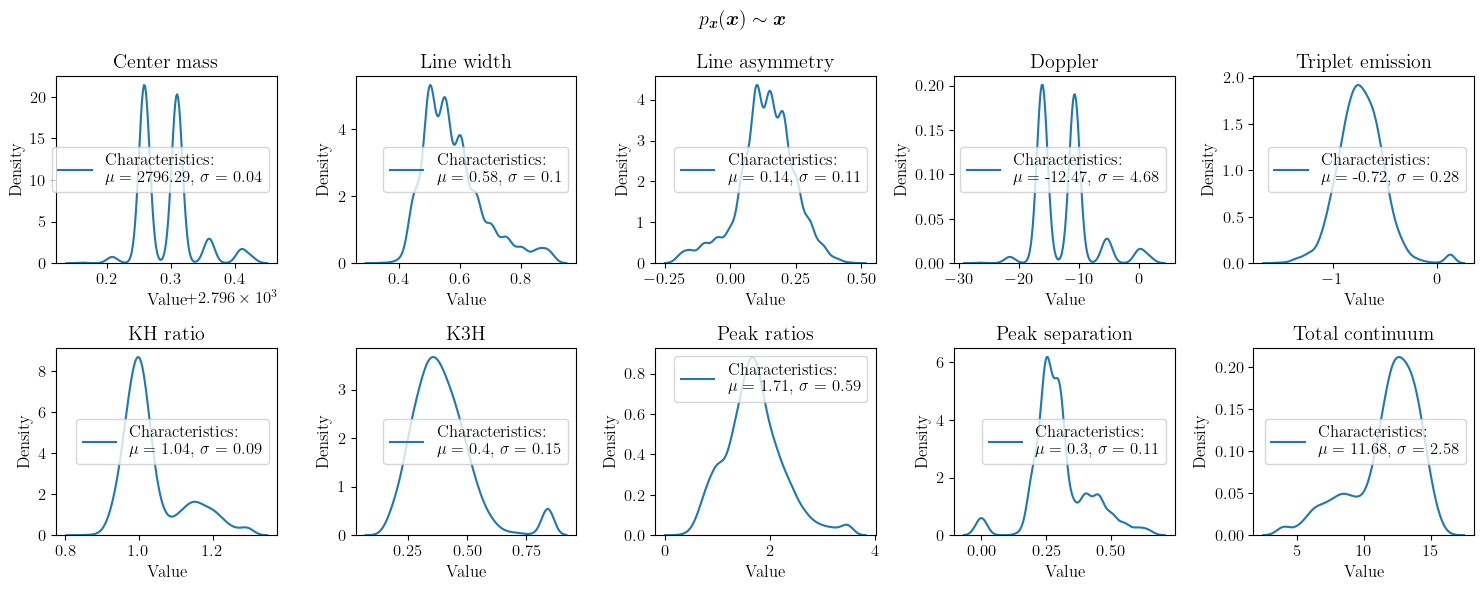

In [20]:
# Examine base distribution of input
plot_dens(x_train, x_train.shape[1], inp_names=labels, title='$p_{\\bm{x}}(\\bm{x}) \\sim \\bm{x}$', savename='nf-feature-extraction-example-3-basedensities.pdf')

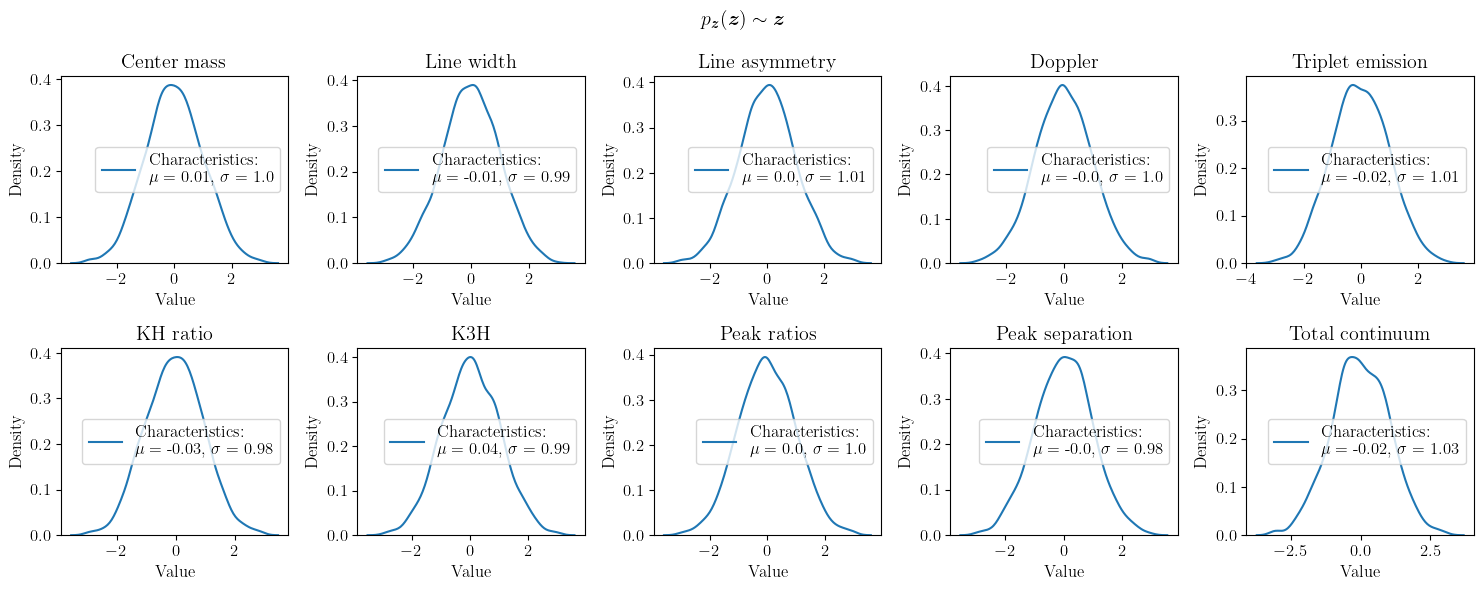

In [21]:
# Examine target distribution of input
plot_dens(z_train, z_train.shape[1], inp_names=labels, title='$p_{\\bm{z}}(\\bm{z}) \\sim \\bm{z}$', savename='nf-feature-extraction-example-3-targetdensities.pdf')

# Define coupling layer and normalizing flow

In [22]:
# Define coupling layer (affine coupling type)
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size, context_size=None):
        'Initializes the coupling layer'
        super().__init__()

        self.D, self.d, self.m, self.h = context_size, input_size, int(input_size/2), hidden_size
        
        if context_size is not None:
            self.net_in = self.m + self.D
        else:
            self.net_in = self.m
        
        self.sig_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

        self.mu_net = nn.Sequential(
                    nn.Linear(self.net_in, self.h),
                    nn.LeakyReLU(),
                    nn.Linear(self.h, (self.d-self.m)))

    def forward(self, x, context=None, flip=False, inverse=False):
        'Defines the forward and inverse direction of the coupling layer'
        x1, x2 = x[:,:self.m], x[:,self.m:]

        if flip:
            x2, x1 = x1, x2

        if context is not None:
            xy = torch.cat([x1, context], dim=-1)
        else:
            xy = x1

        mu = self.mu_net(xy)
        sig = self.sig_net(xy)

        if not inverse:
            z1, z2 = x1, mu + x2 * torch.exp(sig)
        else:
            z1, z2 = x1, (x2 - mu) * torch.exp(-sig)

        if flip:
            z2, z1 = z1, z2 

        z = torch.cat([z1, z2], dim=-1)
        
        pz = MultivariateNormal(torch.zeros(x.shape[1]), torch.eye(x.shape[1]))
        log_pz = pz.log_prob(z)
        
        log_det_J = sig.sum(-1)
                
        return z, log_pz, log_det_J

In [23]:
# Define normalizing flow (RNVP type)
class NormalizingFlow(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, context_size=None):
        'Initializes the normalizing flow architecture'
        super().__init__()
        
        self.bijectors = nn.ModuleList([
            CouplingLayer(input_size, hidden_size, context_size) for _ in range(num_layers)
        ])

        self.flips = [True if i%2 else False for i in range(num_layers)]
        
    def forward(self, x, context=None, inverse=False):
        'Defines the forward and inverse direction of the normalizing flow'
        lg_pz = []
        lg_det_J = []
        
        if not inverse:
            for biijector, f in zip(self.bijectors, self.flips):
                x, lpz, ldj = biijector(x, context=context, inverse=False, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)
        else:
            for biijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
                x, lpz, ldj = biijector(x, context=context, inverse=True, flip=f)
                lg_pz.append(lpz)
                lg_det_J.append(ldj)
        
        return x, sum(lg_pz), sum(lg_det_J)

# Define loss function and dataloader

## Define loss function

In [24]:
# Define loss function
def loss_function(model, input, context=None):
    'Calculates the loss for training a normalizing flow'
    z, log_pz, log_det_J = model(input, context=context, inverse=False)
    loss = -torch.mean(log_pz + log_det_J)
    return loss

## Define dataloader

In [25]:
# Convert training data to PyTorch tensors
x_std_train = torch.tensor(x_std_train, dtype=torch.float32) # Make input x to tensor
y_std_train = torch.tensor(y_std_train, dtype=torch.float32) # Make context y to tensor
z_train = torch.tensor(z_train, dtype=torch.float32) # Make target distribution to tensor

# Convert testing data to PyTorch tensors
x_std_test = torch.tensor(x_std_test, dtype=torch.float32) # Make input x to tensor
y_std_test = torch.tensor(y_std_test, dtype=torch.float32) # Make context y to tensor
z_test = torch.tensor(z_test, dtype=torch.float32) # Make target distribution to tensor

In [26]:
# Print sizes of training data
print(f'Size of x_std_train: {x_std_train.size()}')
print(f'Size of y_std_train: {y_std_train.size()}')
print(f'Size of z_train: {z_train.size()}')

# Print sizes of testing data
print(f'Size of x_std_test: {x_std_test.size()}')
print(f'Size of y_std_test: {y_std_test.size()}')
print(f'Size of z_test: {z_test.size()}')

Size of x_std_train: torch.Size([4018, 10])
Size of y_std_train: torch.Size([4018, 240])
Size of z_train: torch.Size([4018, 10])
Size of x_std_test: torch.Size([1005, 10])
Size of y_std_test: torch.Size([1005, 240])
Size of z_test: torch.Size([1005, 10])


In [27]:
# Define dataloaders for training and testing
settings.batch_size = 512
dataset_train = torch.utils.data.TensorDataset(x_std_train, y_std_train) # Input: x, context: y
dataset_test = torch.utils.data.TensorDataset(x_std_test, y_std_test) # Input: x, context: y
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=settings.batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=settings.batch_size, shuffle=True)

# Instantiate normalizing flow and training settings

In [28]:
# Settings for model
settings.input_size = np.array(x_std_train).shape[1]
settings.context_size = np.array(y_std_train).shape[1]
settings.hidden_size = 256
settings.num_layers = 6

# Instantiate the normalizing flow
normalizing_flow_feat_extract = NormalizingFlow(settings.input_size, settings.hidden_size, settings.num_layers, context_size=settings.context_size)

In [29]:
# Settings for training
settings.learning_rate = 1e-3
settings.scheduling_rate = 0.999
settings.num_epochs = 35

# Define optimizer and scheduler
optim = torch.optim.Adam(normalizing_flow_feat_extract.parameters(), lr=settings.learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, settings.scheduling_rate)

# Train and test the flow

## Train the flow
Train normalizing flow on a dataset containing spectra and corresponding features of two quite different categories. These categories of spectra are separated using a k-means algorithm prior to training the normalizing flow. As a result, a test spectrum of one of the two categories propagated through the normalizing flow should lead to a feature distribution corresponding to a mean value of the features in the respective category.

In [30]:
# Train the flow
train_losses = []
test_losses = []
epochs = []
for epoch in range(settings.num_epochs):
    epoch_train_losses = []
    epoch_test_losses = []
    for batch_x, batch_y in dataloader_train:
        normalizing_flow_feat_extract.train()
        optim.zero_grad()
        loss = loss_function(normalizing_flow_feat_extract, batch_x, context=batch_y)
        loss.backward()
        optim.step()
        scheduler.step()
        epoch_train_losses.append(loss.detach())
    for batch_x, batch_y in dataloader_test:
        normalizing_flow_feat_extract.eval()
        loss = loss_function(normalizing_flow_feat_extract, batch_x, context=batch_y)
        epoch_test_losses.append(loss.detach())
    epoch_train_loss = sum(epoch_train_losses)/len(dataset_train)
    epoch_test_loss = sum(epoch_test_losses)/len(dataset_test)
    train_losses.append(epoch_train_loss)
    test_losses.append(epoch_test_loss)
    epochs.append(epoch)
    if (epoch+1) % 1 == 0:
        print('Epoch {}/{} train loss: {:.4f}'.format(epoch+1, settings.num_epochs, epoch_train_loss))

Epoch 1/35 train loss: 0.1927
Epoch 2/35 train loss: 0.1536
Epoch 3/35 train loss: 0.1394
Epoch 4/35 train loss: 0.1335
Epoch 5/35 train loss: 0.1278
Epoch 6/35 train loss: 0.1225
Epoch 7/35 train loss: 0.1192
Epoch 8/35 train loss: 0.1170
Epoch 9/35 train loss: 0.1138
Epoch 10/35 train loss: 0.1149
Epoch 11/35 train loss: 0.1153
Epoch 12/35 train loss: 0.1157
Epoch 13/35 train loss: 0.1138
Epoch 14/35 train loss: 0.1116
Epoch 15/35 train loss: 0.1084
Epoch 16/35 train loss: 0.1066
Epoch 17/35 train loss: 0.1049
Epoch 18/35 train loss: 0.1064
Epoch 19/35 train loss: 0.1066
Epoch 20/35 train loss: 0.1144
Epoch 21/35 train loss: 0.1176
Epoch 22/35 train loss: 0.1196
Epoch 23/35 train loss: 0.1180
Epoch 24/35 train loss: 0.1144
Epoch 25/35 train loss: 0.1101
Epoch 26/35 train loss: 0.1073
Epoch 27/35 train loss: 0.1051
Epoch 28/35 train loss: 0.1031
Epoch 29/35 train loss: 0.1015
Epoch 30/35 train loss: 0.1045
Epoch 31/35 train loss: 0.1087
Epoch 32/35 train loss: 0.1085
Epoch 33/35 train

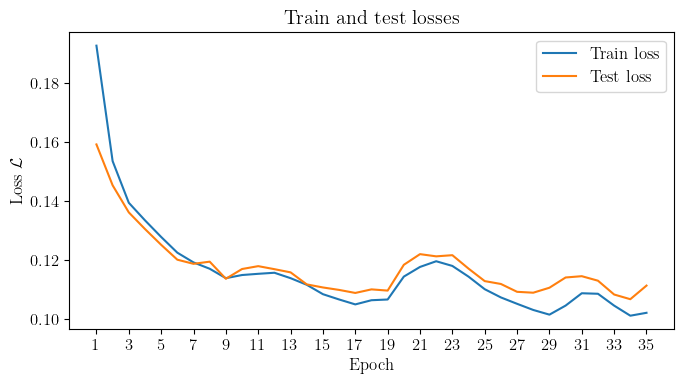

In [31]:
# Print train and test losses
#train_losses_s = (np.array(train_losses)-np.min(train_losses))/np.max(np.array(train_losses)-np.min(train_losses))
#test_losses_s = (np.array(test_losses)-np.min(test_losses))/np.max(np.array(test_losses)-np.min(test_losses))
plt.figure(figsize=(7,4))
plt.title('Train and test losses')
plt.xlabel('Epoch')
plt.ylabel('Loss $\\mathcal{L}$')
x_ticks = np.array(epochs) + 1
ticks_param = int(len(epochs)/15)
selected_ticks = np.array(epochs)[::ticks_param]
plt.xticks(selected_ticks, x_ticks[selected_ticks])
plt.plot(np.array(epochs), train_losses, label='Train loss')
plt.plot(np.array(epochs), test_losses, label='Test loss')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('nf-feature-extraction-example-3-loss.pdf')

## Test the flow
Take the centroid spectrum of both categories and check, whether the feature distribution given by the normalizing flow based on these centorid spectra correspond to the calculated feature values of said centroid spectra.

Take also the whole dataset of features and spectra and propagate it backwards through the normalizing flow to see the latent representation of the features (should be Gaussian distributed).

In [32]:
# Set amount of test samples
settings.exp_samples = 10000

In [33]:
# Take the centroid spectrum of the first category as a test sample
expobs1 = np.array(cat1_centroid)
expval1 = torch.tensor(np.array(extract_features(np.vstack((expobs1, expobs1))))[0,:])
z_exp1 = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp1 = torch.tensor(np.repeat(expobs1[None,:], z_exp1.shape[0], axis=0))
y_exp1_std = torch.tensor(y_scaler_test.transform(y_exp1), dtype=torch.float32)

# Propagate it through the inverse normalizing flow
rec_x1_std, _, _ = normalizing_flow_feat_extract(z_exp1, context=y_exp1_std, inverse=True)
rec_x1_std = rec_x1_std.detach().numpy()
rec_x1 = x_scaler_test.inverse_transform(rec_x1_std)

# Take the centroid spectrum of the second category as a test sample
expobs2 = np.array(cat2_centroid)
expval2 = torch.tensor(np.array(extract_features(np.vstack((expobs2, expobs2))))[0,:])
z_exp2 = MultivariateNormal(torch.zeros(x_std_test.shape[1]), torch.eye(x_std_test.shape[1])).rsample(sample_shape=(settings.exp_samples,))
y_exp2 = torch.tensor(np.repeat(expobs2[None,:], z_exp2.shape[0], axis=0))
y_exp2_std = torch.tensor(y_scaler_test.transform(y_exp2), dtype=torch.float32)

# Propagate it through the inverse normalizing flow
rec_x2_std, _, _ = normalizing_flow_feat_extract(z_exp2, context=y_exp2_std, inverse=True)
rec_x2_std = rec_x2_std.detach().numpy()
rec_x2 = x_scaler_test.inverse_transform(rec_x2_std)

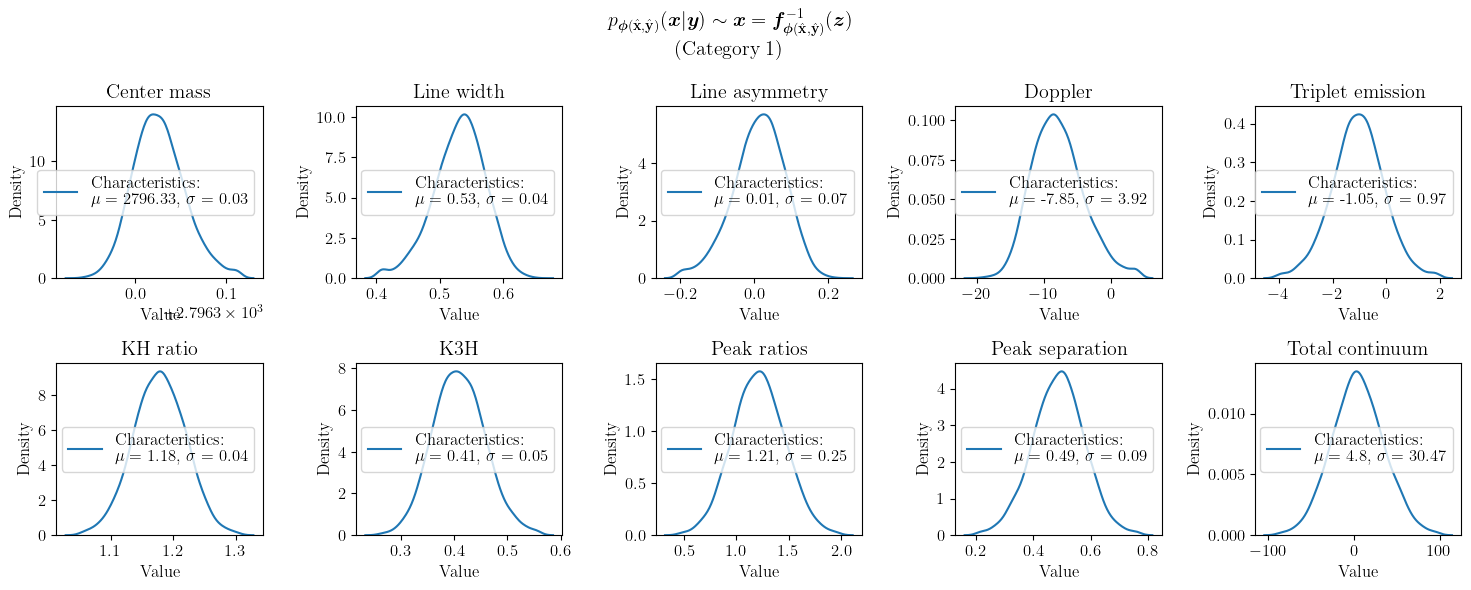

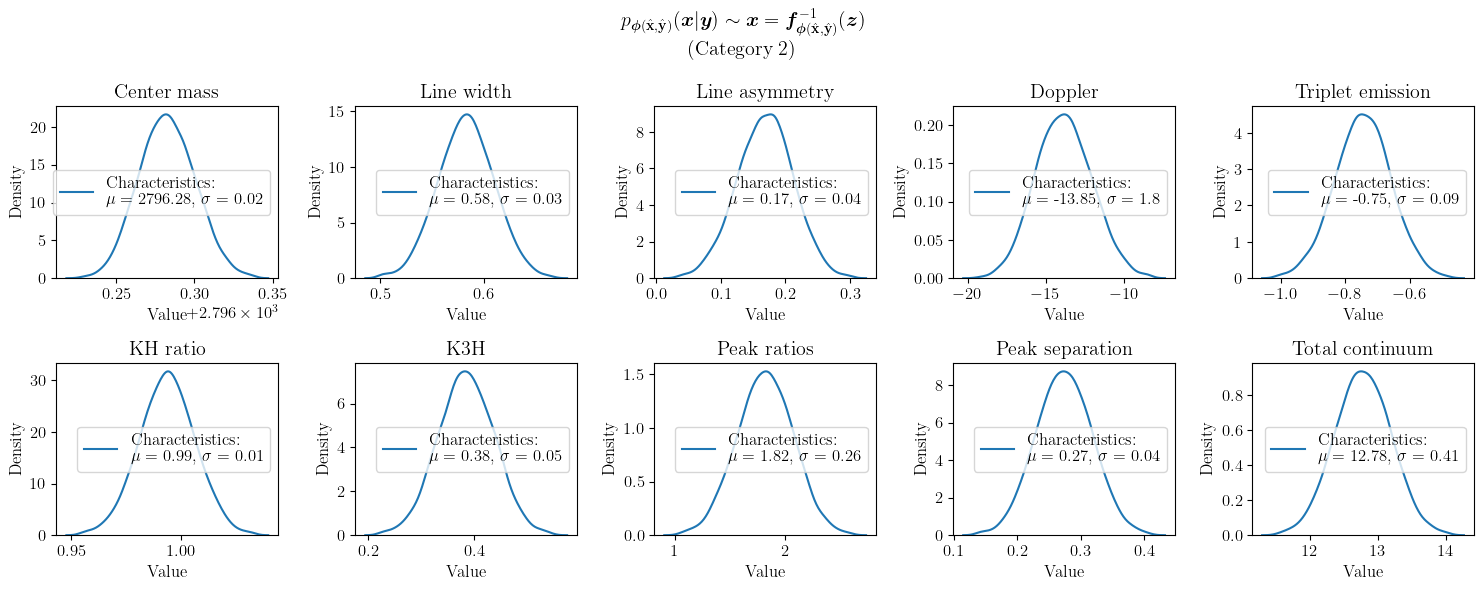

In [34]:
# Plot results for centroid spectrum of category 1
plot_dens(rec_x1, rec_x1.shape[1], inp_names=labels, title='$p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = \\bm{f}^{-1}_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{z})$\n(Category 1)', savename='nf-feature-extraction-example-3-calcbasedensities-cat1.pdf')

# Plot results for centroid spectrum of category 1
plot_dens(rec_x2, rec_x2.shape[1], inp_names=labels, title='$p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = \\bm{f}^{-1}_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{z})$\n(Category 2)', savename='nf-feature-extraction-example-3-calcbasedensities-cat2.pdf')

In [35]:
# Plot actual values of features for tested spectra
print('Features for centroid spectrum of category 1:')
for i in range(len(labels)):
    print(f'{labels[i]}: {expval1[i]}')
    
print('\n\nFeatures for centroid spectrum of category 2:')
for i in range(len(labels)):
    print(f'{labels[i]}: {expval2[i]}')

Features for centroid spectrum of category 1:
Center mass: 2796.31
Line width: 0.552
Line asymmetry: 0.05
Doppler: -10.773
Triplet emission: -0.612
KH ratio: 1.174
K3H: 0.413
Peak ratios: 1.094
Peak separation: 0.402
Total continuum: 7.784


Features for centroid spectrum of category 2:
Center mass: 2796.259
Line width: 0.603
Line asymmetry: 0.201
Doppler: -16.16
Triplet emission: -0.752
KH ratio: 0.995
K3H: 0.409
Peak ratios: 1.712
Peak separation: 0.301
Total continuum: 12.861


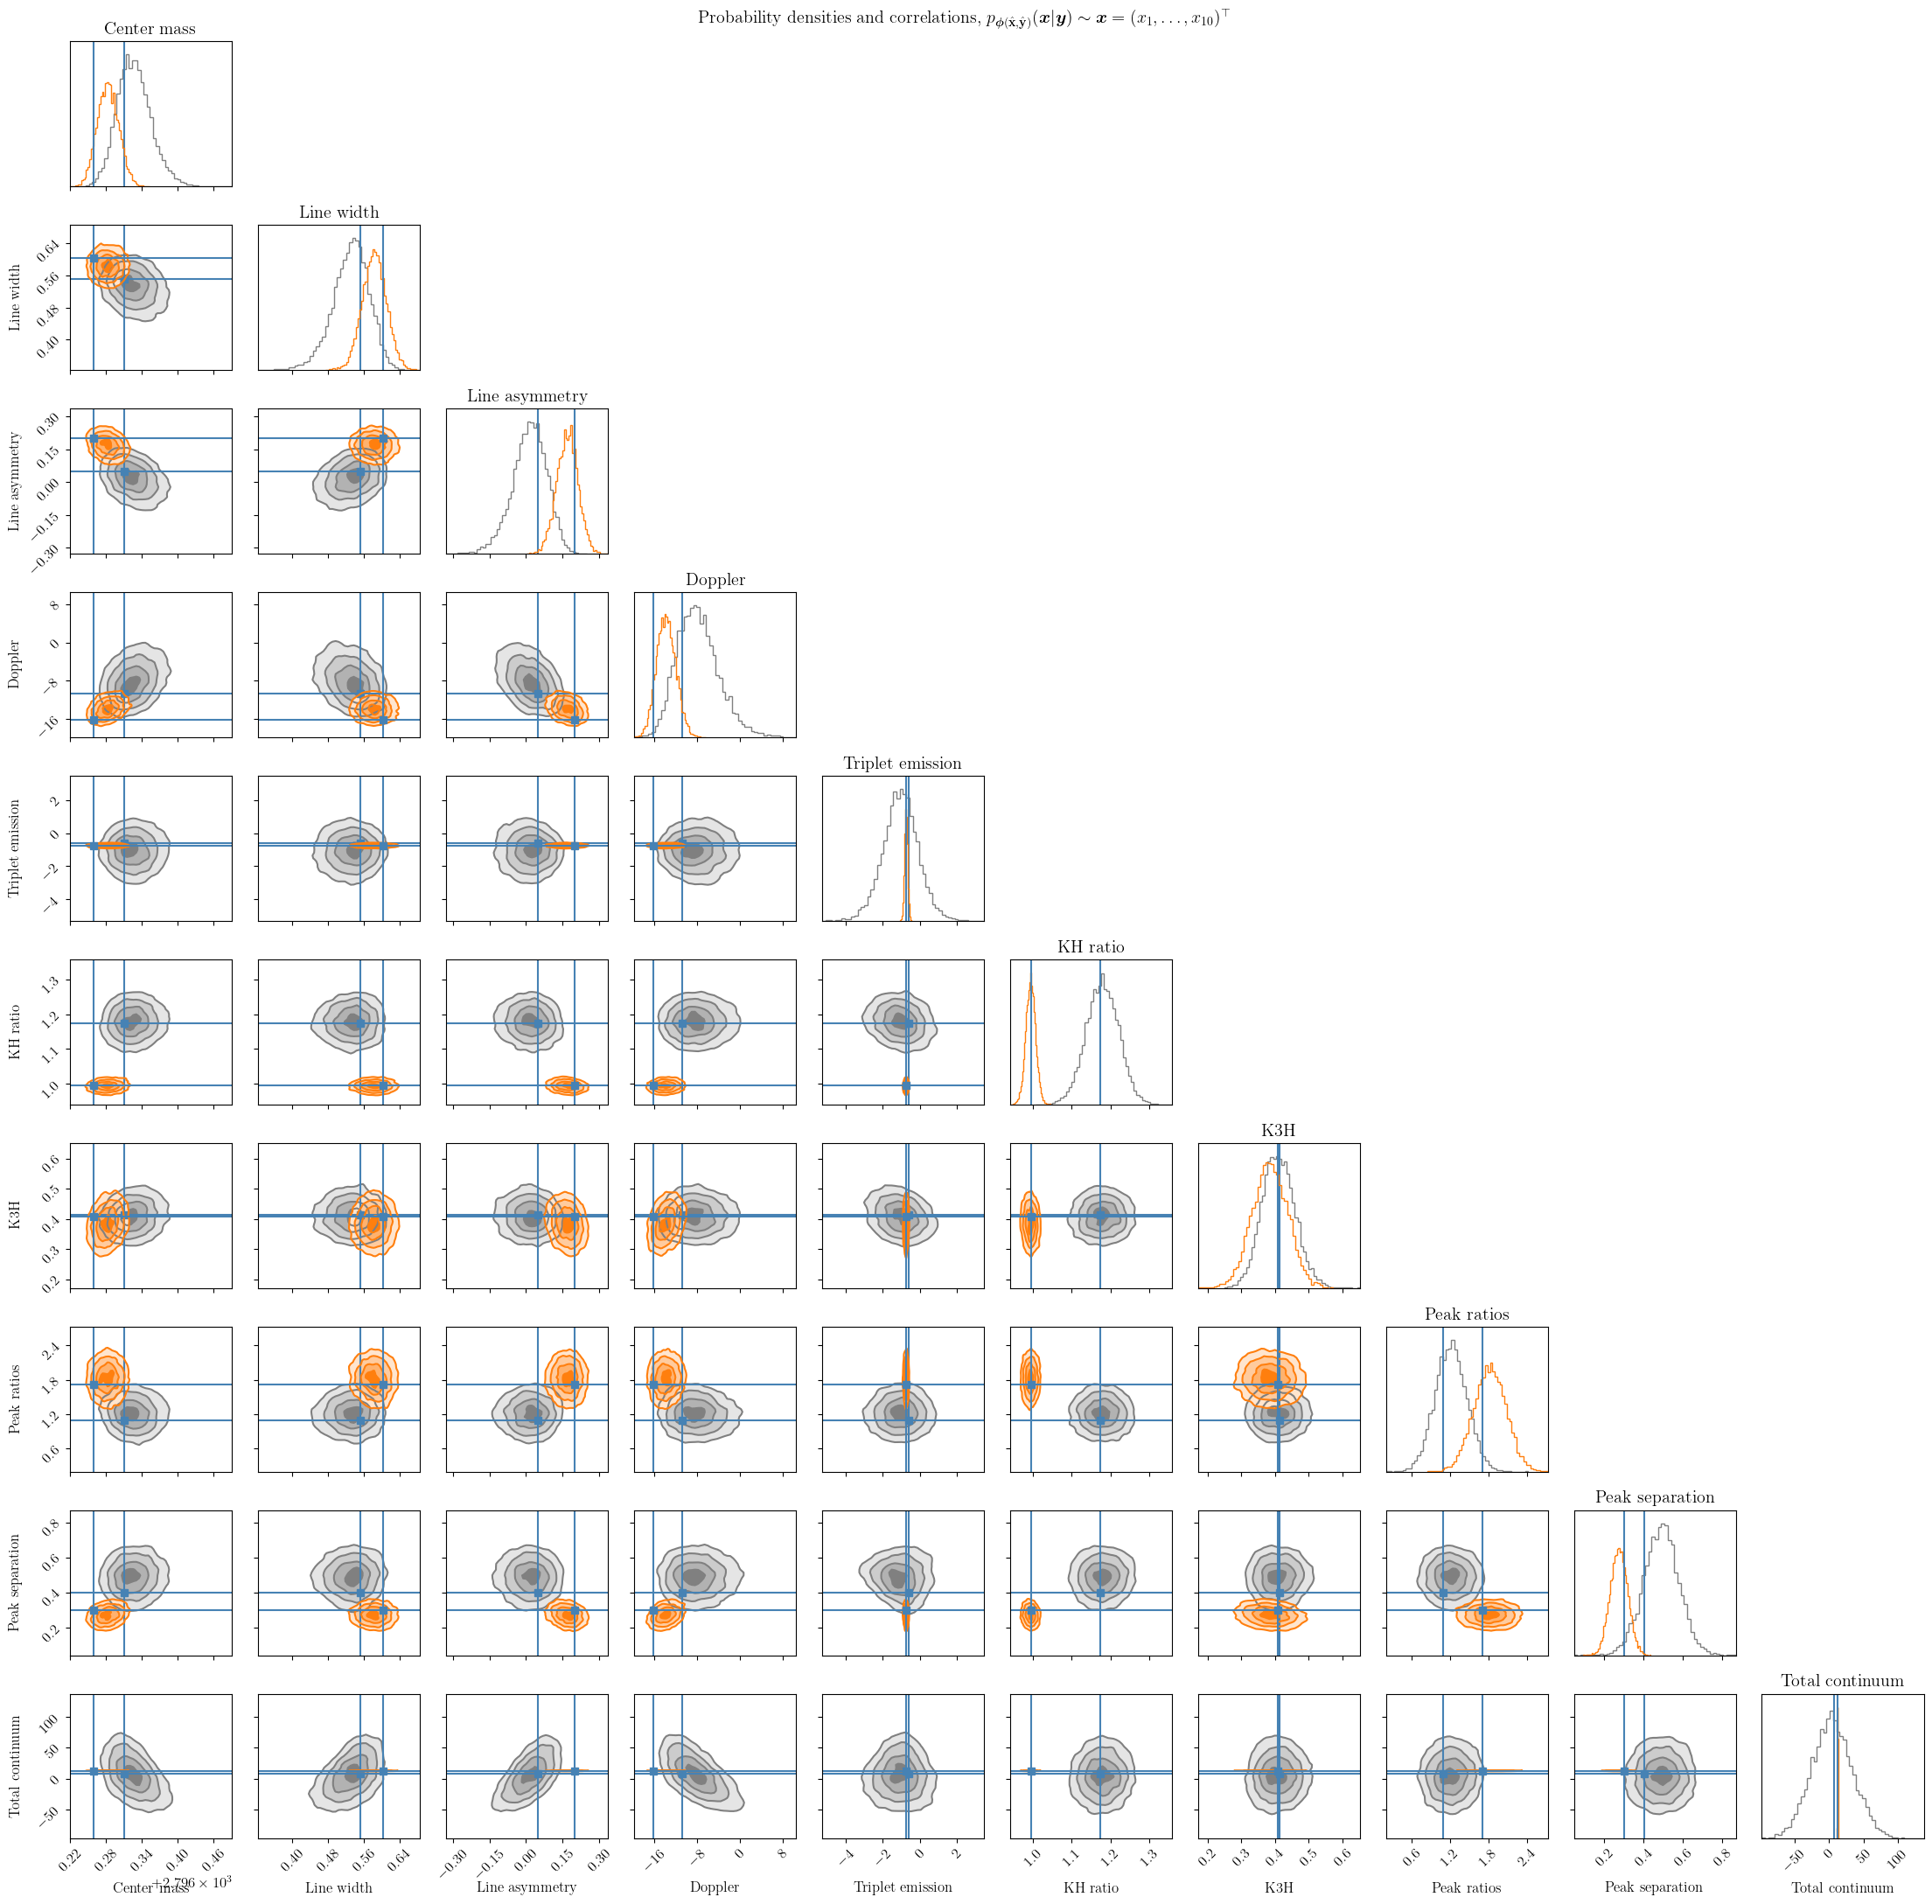

In [36]:
# Produce corner plot
figure = corner.corner(rec_x1, labels=labels, truths=expval1, show_titles=True, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, color='gray', title_fmt=None)
_ = corner.corner(rec_x2, labels=labels, truths=expval2, show_titles=True, plot_datapoints=False, fill_contours=True, bins=50, smooth=1.0, fig=figure, color='C1', title_fmt=None)
plt.suptitle('Probability densities and correlations, $p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y}) \\sim \\bm{x} = (x_1,\\dots,x_{10})^\\top$')
plt.tight_layout()
plt.savefig('nf-feature-extraction-example-3-corner.pdf')

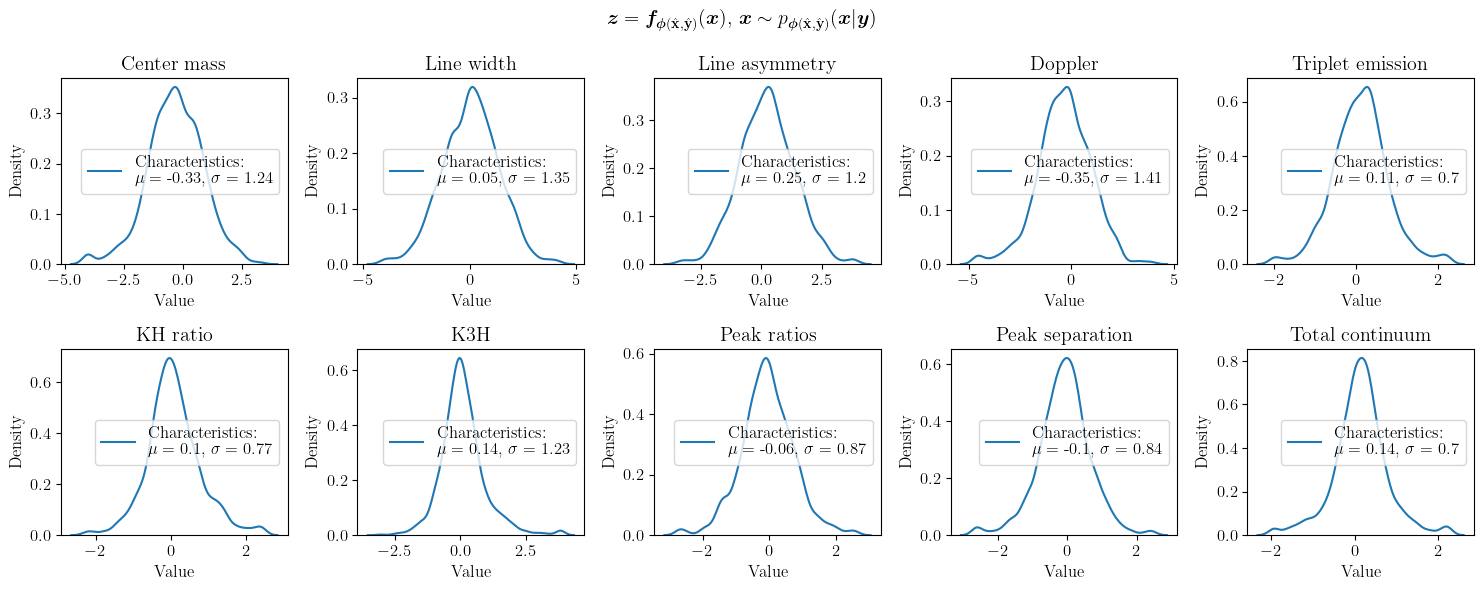

In [37]:
# Propagate it through the inverse normalizing flow to see latent space of test data
lat_x_std_test, _, _ = normalizing_flow_feat_extract(x_std_test, context=y_std_test)
lat_x_std_test = lat_x_std_test.detach().numpy()

# Plot results
plot_dens(lat_x_std_test, lat_x_std_test.shape[1], inp_names=labels, title='$\\bm{z} = \\bm{f}_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x})$, $\\bm{x} \\sim p_{\\bm{\phi}(\\hat{\\mathbf{x}},\\hat{\\mathbf{y}})}(\\bm{x}|\\bm{y})$', savename='nf-feature-extraction-example-3-calctargetdensities.pdf')

In [38]:
# Print settings for training and testing
for key, value in settings.items():
    print(key, ' : ', value)

batch_size  :  512
input_size  :  10
context_size  :  240
hidden_size  :  256
num_layers  :  6
learning_rate  :  0.001
scheduling_rate  :  0.999
num_epochs  :  35
exp_samples  :  10000
